In [ ]:
import nibabel
from nibabel import freesurfer
import nibabel.affines
from PIL import Image
import os
import fnmatch
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import ants

np.set_printoptions(precision=2, suppress=True)

print("hello")

In [42]:
def load_image(data_path, filename):
    
    return nibabel.load(f"{data_path}/{filename}")

# Display the middle slice of a nibabel image
def display_image(image):

    # Get image data array from image object
    image_array = np.asarray(image.dataobj)
    
    # Get middle slice
    slice = image_array[image_array.shape[0] // 2, :, :]
    
    # Scale the image such that the maximum pixel value is 255
    # Display the scaled image
    display(Image.fromarray(((slice / np.max(slice)) * 255).astype(np.uint8)))
    
    return 

def display_array(array):
    
    # Get middle slice
    slice = array[array.shape[0] // 2, :, :]
    
    # Scale the image such that the maximum pixel value is 255
    # Display the scaled image
    display(Image.fromarray(((slice / np.max(slice)) * 255).astype(np.uint8)))
    
    return 

# Find files with a specific filename and return a list. Non-recursive 
def list_files_ext(data_path, extensions):

    files = [f for f in os.listdir(data_path) if f.endswith(extensions)]
        
    return files       

# Return the absolute path to all files matching a filename in a directory. Recursive
def list_files_fname(data_path, filename):
    
    matched_files = []
    
    for root, dirs, files in os.walk(data_path):
        
        for file in fnmatch.filter(files, filename):
            
            matched_files.append(os.path.join(root, file))
    
    return matched_files

# Returns a list of tuples, each containing an orig_nu.mgz and mask.mgz of a subject
def get_mask(data_path):
    
    brain_mask_list = []

    for item in os.listdir(data_path):
        
        subject_path = os.path.join(data_path, item)
        
        if os.path.isdir(subject_path):
            
            # MRI directory of subject path
            mri_path = os.path.join(subject_path, 'mri')
            
            # Check for MRI directory
            if os.path.isdir(mri_path):
                
                orig_file = os.path.join(mri_path, 'orig_nu.mgz')
                
                mask_file = os.path.join(mri_path, 'mask.mgz')

                # If both orig.mgz and mask.mgz exist, add them to the result
                if os.path.isfile(orig_file) and os.path.isfile(mask_file):
                    
                    brain_mask_list.append((orig_file, mask_file))

    return brain_mask_list
        

In [ ]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch disk/preprocess-sample/mri"


display_image(load_image("/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch disk/preprocess-sample/", "ADNI_002_S_0413_MR_MPR____N3__Scaled_Br_20070804124954957_S32945_I64551.nii"))

for filename in list_files_ext(data_path, ('.nii', '.nii.gz', '.mgz')):
    
    print(filename + ":\n")
    
    display_image(load_image(data_path, filename))
    
    print()
    print()   
    

In [ ]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch disk/full-datasets/adni1-complete-1yr-3t"

# Display the brain mask of every patient in the datset
fpath_list = list_files_fname(data_path, "mask.mgz")


print(f"{len(fpath_list)}\n")

for file in fpath_list:
    
    #display_image(nibabel.load(file))
    
    pass

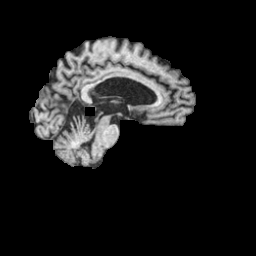

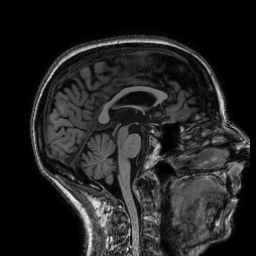

(256, 256, 256)


KeyboardInterrupt: 

In [ ]:
for subject in get_mask(data_path):
    
    # Load the image and the brain mask
    image = nibabel.load(subject[0])
    mask = nibabel.load(subject[1])
    
    # Get their image arrays
    image_array = np.asarray(image.dataobj)
    mask_array = np.asarray(mask.dataobj)
    
    # NB these prints were 0 matrices therefore affine of mask and image are the same
    # print(image.affine - mask.affine)

    # Apply the mask, the mask entries are 1 or 0
    brain_array = image_array * mask_array
    
    # Display the brain array
    display_array(brain_array)
    
    fixed_image = ants.image_read(ants.get_ants_data('mni'))

    #fixed_image_resampled = ants.resample_image_to_target(fixed_image, ants.from_numpy(image_array), 'nearestNeighbor')

    fixed_image_array = fixed_image.numpy()
    
    display_array(fixed_image_array)

    print(fixed_image_array.shape)
    
    moving_image = ants.from_numpy(brain_array)
    
    registration = ants.registration(fixed = fixed_image, moving = moving_image, type_of_transform='SyN')
    
    registration['warpedmovout'].plot()

    break

            